<a href="https://colab.research.google.com/github/mems250005048-wq/GDG/blob/main/GDG_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
import yfinance as yf
import pandas as pd

# Download historical data
ticker = "AAPL"
df = yf.download(ticker, start="2018-01-01", end="2024-01-01")

# Clean columns
df.reset_index(inplace=True)
df.rename(columns={
    "Date": "date",
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Volume": "volume"
}, inplace=True)

# Save CSV
df.to_csv("AAPL_OHLCV.csv", index=False)

print("AAPL OHLCV CSV created successfully")


/tmp/ipython-input-3320495629.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed

AAPL OHLCV CSV created successfully


In [3]:

print(df.head())

Price        date      close       high        low       open     volume
Ticker                  AAPL       AAPL       AAPL       AAPL       AAPL
0      2018-01-02  40.341885  40.351254  39.639309  39.850084  102223600
1      2018-01-03  40.334858  40.878185  40.271629  40.405116  118071600
2      2018-01-04  40.522224  40.625269  40.299743  40.407469   89738400
3      2018-01-05  40.983570  41.070220  40.526897  40.618231   94640000
4      2018-01-08  40.831341  41.126421  40.732977  40.831341   82271200


In [4]:
# Create a new column called 'Log_Ret'
# This calculates: ln(Price Today / Price Yesterday)
df['Log_Ret'] = np.log(df['close'] / df['close'].shift(1))

# Because the first day has no 'Yesterday', it will be empty (NaN).
# We must remove it or the math will break.
df = df.dropna()

print(df[['close', 'Log_Ret']].head())

Price       close   Log_Ret
Ticker       AAPL          
1       40.334858 -0.000174
2       40.522224  0.004635
3       40.983570  0.011321
4       40.831341 -0.003721
5       40.826664 -0.000115


In [5]:
# Calculate the 'Spread' (High minus Low, relative to the Close price)
df['HL_Spread'] = (df['high'] - df['low']) / df['close']

print(df[['high', 'low', 'HL_Spread']].head())

Price        high        low HL_Spread
Ticker       AAPL       AAPL          
1       40.878185  40.271629  0.015038
2       40.625269  40.299743  0.008033
3       41.070220  40.526897  0.013257
4       41.126421  40.732977  0.009636
5       40.997623  40.611208  0.009465


In [6]:


# Run the test on our Log Returns
result = adfuller(df['Log_Ret'])

# Extract the p-value (it's the second item in the result)
p_value = result[1]

print(f"ADF Statistic: {result[0]:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("--- SUCCESS: Data is Stationary ---")
else:
    print("--- WARNING: Data is NOT Stationary ---")

ADF Statistic: -12.1504
P-Value: 0.0000
--- SUCCESS: Data is Stationary ---


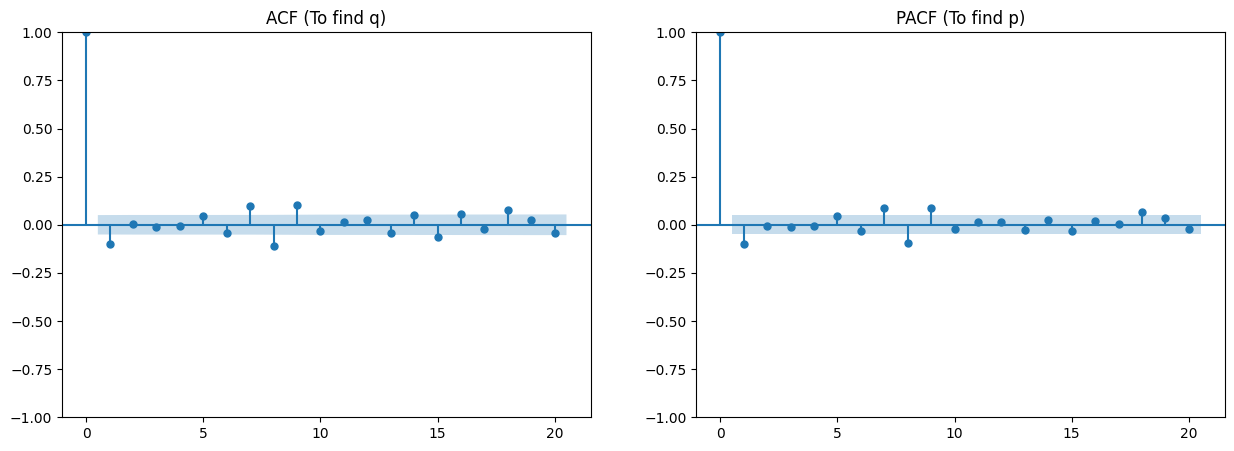

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a side-by-side view
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ACF Plot - Helps find 'q' (Moving Average)
plot_acf(df['Log_Ret'], ax=ax1, lags=20)
ax1.set_title('ACF (To find q)')

# PACF Plot - Helps find 'p' (Auto-Regression)
plot_pacf(df['Log_Ret'], ax=ax2, lags=20)
ax2.set_title('PACF (To find p)')

plt.show()

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Let's start with p=1, d=0, q=1 (a very standard starting point)
# Note: d=0 because we already differenced the data manually with Log Returns!
p, d, q = 1, 0, 1

# Define the model
# endog = what we predict (Log_Ret)
# exog = our extra hint (HL_Spread)
model = SARIMAX(df['Log_Ret'],
                exog=df[['HL_Spread']],
                order=(p, d, q))

# Train the model
results = model.fit(disp=False)

# Look at the Report Card
print(results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Log_Ret   No. Observations:                 1508
Model:               SARIMAX(1, 0, 1)   Log Likelihood                3767.973
Date:                Sat, 17 Jan 2026   AIC                          -7527.947
Time:                        18:56:54   BIC                          -7506.673
Sample:                             0   HQIC                         -7520.023
                               - 1508                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
HL_Spread     -0.0098      0.011     -0.855      0.393      -0.032       0.013
ar.L1         -0.0895      0.174     -0.515      0.607      -0.430       0.251
ma.L1         -0.0080      0.179     -0.045      0.9

In [9]:
# 1. We need 'hints' (exogenous data) for the future 7 days
# We will just use the average HL_Spread from the last month
avg_spread = df['HL_Spread'].tail(30).mean()
future_exog = np.full((7, 1), avg_spread)

# 2. Ask the model for the 7-day forecast
forecast_obj = results.get_forecast(steps=7, exog=future_exog)

# 3. Get the Log Return predictions and the 'Shadow' (Confidence Intervals)
forecast_log_rets = forecast_obj.predicted_mean
confidence_intervals = forecast_obj.conf_int()

print("Predicted Log Returns for next 7 days:")
print(forecast_log_rets)

Predicted Log Returns for next 7 days:
1508    0.000399
1509   -0.000162
1510   -0.000112
1511   -0.000116
1512   -0.000116
1513   -0.000116
1514   -0.000116
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [10]:
# 1. Use .item() or .values[0] to ensure we get a single number, not a list
last_real_price = df['close'].iloc[-1]

# If last_real_price is still a Series, this line forces it to a float
if isinstance(last_real_price, pd.Series):
    last_real_price = last_real_price.iloc[0]

# 2. Calculate the Cumulative Sum (same as before)
cumulative_changes = np.cumsum(forecast_log_rets)

# 3. Apply the Exponential function
forecast_prices = last_real_price * np.exp(cumulative_changes)
forecast_prices.name = "Predicted_Close"

# 4. Now the formatting will work because it's a single float!
print(f"Starting Price: {float(last_real_price):.2f}")
print("\n--- 7-Day Price Forecast ---")
print(forecast_prices)

Starting Price: 190.73

--- 7-Day Price Forecast ---
1508    190.804934
1509    190.774008
1510    190.752672
1511    190.730481
1512    190.708368
1513    190.686252
1514    190.664139
Name: Predicted_Close, dtype: float64


In [11]:
# 1. Split data into "Past" and "Test" (last 10 days)
train_data = list(df['Log_Ret'][:-10])
test_data = list(df['Log_Ret'][-10:])
exog_data = list(df['HL_Spread'][:-10])
test_exog = list(df['HL_Spread'][-10:])

predictions = []

# 2. The Rolling Loop
print("Starting Rolling Validation...")
for i in range(len(test_data)):
    # Train the model on all data available up to this point
    model = SARIMAX(train_data, exog=exog_data, order=(1, 0, 1))
    model_fit = model.fit(disp=False)

    # Predict the next 1 day (using the current day's spread as the hint)
    obs_exog = [[test_exog[i]]]
    yhat = model_fit.forecast(steps=1, exog=obs_exog)

    # Save the prediction
    predictions.append(yhat[0])

    # ADD the actual observed data to our training set for the next round
    train_data.append(test_data[i])
    exog_data.append(test_exog[i])
    print(f"Day {i+1}: Predicted={yhat[0]:.4f}, Actual={test_data[i]:.4f}")

print("\nValidation Complete.")

Starting Rolling Validation...
Day 1: Predicted=-0.0002, Actual=-0.0027
Day 2: Predicted=0.0002, Actual=-0.0085
Day 3: Predicted=0.0008, Actual=0.0053
Day 4: Predicted=-0.0007, Actual=-0.0108
Day 5: Predicted=0.0009, Actual=-0.0008
Day 6: Predicted=-0.0001, Actual=-0.0056
Day 7: Predicted=0.0005, Actual=-0.0028
Day 8: Predicted=0.0002, Actual=0.0005
Day 9: Predicted=-0.0001, Actual=0.0022
Day 10: Predicted=-0.0004, Actual=-0.0054

Validation Complete.


In [12]:
from sklearn.metrics import mean_squared_error

# Calculate how far off we were on average
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)

print(f"Model RMSE: {rmse:.5f}")

Model RMSE: 0.00530


In [13]:
! pip install streamlit -q

In [14]:
!wget -q -O - ipv4.icanhazip.com

34.125.11.221


In [15]:
!ps -ef | grep streamlit

root       11304   11096  0 18:57 ?        00:00:00 /bin/bash -c ps -ef | grep streamlit
root       11306   11304  0 18:57 ?        00:00:00 grep streamlit


In [20]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Use the full name here for better compatibility
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

st.set_page_config(page_title="AI Stock Forecaster Pro", layout="wide")

st.title("📈 AI Stock Volatility & Price Forecaster")
st.write("Professional Dashboard: Historical Backtesting + 7-Day Forecasting")

# 1. Load & Clean Data
@st.cache_data
def load_data():
    df = pd.read_csv('AAPL_OHLCV.csv')
    df.columns = [c.strip().capitalize() for c in df.columns]
    for col in ['Close', 'High', 'Low']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].replace(r'[\$,]', '', regex=True), errors='coerce')
    df.dropna(subset=['Close', 'High', 'Low'], inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)
    return df

try:
    df = load_data()

    # 2. Preprocessing
    df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))
    df['HL_Spread'] = (df['High'] - df['Low']) / df['Close']
    df.dropna(inplace=True)

    # 3. Model Training
    p, q = 1, 1
    model = SARIMAX(df['Log_Ret'], exog=df[['HL_Spread']], order=(p, 0, q))
    results = model.fit(disp=False)

    # --- BACKTESTING (Plotting predictions for past data) ---
    backtest_days = 30
    historical_preds_log = results.predict(start=-backtest_days)
    prev_prices = df['Close'].shift(1).iloc[-backtest_days:]
    historical_preds_price = prev_prices * np.exp(historical_preds_log)

    # --- METRICS CALCULATION (Corrected for Compatibility) ---
    actuals = df['Close'].iloc[-backtest_days:]
    mae_val = mean_absolute_error(actuals, historical_preds_price)

    # Manually calculate MAPE if the function fails or use the full name
    mape_val = mean_absolute_percentage_error(actuals, historical_preds_price)
    accuracy = (1 - mape_val) * 100

    # 4. FUTURE FORECAST (7 Days)
    avg_spread = df['HL_Spread'].mean()
    future_exog = np.full((7, 1), avg_spread)
    forecast_obj = results.get_forecast(steps=7, exog=future_exog)

    last_price = float(df['Close'].iloc[-1])
    forecast_prices = last_price * np.exp(np.cumsum(forecast_obj.predicted_mean))
    conf_int = forecast_obj.conf_int()
    lower_bounds = last_price * np.exp(np.cumsum(conf_int.iloc[:, 0]))
    upper_bounds = last_price * np.exp(np.cumsum(conf_int.iloc[:, 1]))

    # 5. VISUALIZATION
    st.subheader("Historical Trends & Projected Forecast")
    fig, ax = plt.subplots(figsize=(12, 6))

    history_plot = df['Close'].tail(60)
    ax.plot(history_plot.index, history_plot, label="Actual Price", color='black', alpha=0.6)
    ax.plot(historical_preds_price.index, historical_preds_price, label="Past Predictions", color='orange', linestyle=':')

    forecast_dates = pd.date_range(start=df.index[-1], periods=8, freq='D')[1:]
    ax.plot(forecast_dates, forecast_prices, label="7-Day AI Projection", color='blue', linewidth=2)
    ax.fill_between(forecast_dates, lower_bounds, upper_bounds, color='blue', alpha=0.2, label="Confidence Interval")

    ax.legend()
    st.pyplot(fig)

    # 6. METRICS DISPLAY
    st.subheader("Model Performance Metrics")
    m1, m2, m3 = st.columns(3)
    m1.metric("Model Accuracy", f"{accuracy:.2f}%")
    m2.metric("Mean Absolute Error", f"${mae_val:.2f}")
    m3.metric("7-Day Target", f"${forecast_prices.iloc[-1]:.2f}")

except Exception as e:
    st.error(f"Logic Error: {e}")

Overwriting app.py


In [ ]:
# 1. Install Cloudflare's tunnel tool
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

# 2. Run Streamlit in the background
import os
os.system("nohup streamlit run app.py --server.port 8501 > log.txt 2>&1 &")

# 3. Create the Cloudflare tunnel
!cloudflared tunnel --url http://localhost:8501

--2026-01-17 19:01:54--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64.deb [following]
--2026-01-17 19:01:54--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64.deb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/8a32f7c6-649c-4f0d-806d-e14c19d0786d?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-01-17T19%3A49%3A06Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64.deb&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4d